# Neural machine translation with attention

https://www.tensorflow.org/tutorials/text/nmt_with_attention

## Requirements

In [ ]:
import tensorflow as tf

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
import json
import operator
from collections import defaultdict

import nltk

## Dataset

In [ ]:
path_to_file = "la-en.txt"

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
#MAX_LENGTH = 50

#def filterPair(p):
#    return len(p[0].split(' ')) < MAX_LENGTH and \
#        len(p[1].split(' ')) < MAX_LENGTH


#def filterPairs(pairs):
#    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  #word_pairs = filterPairs(pairs)

  return zip(*pairs)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
# BLEU score
# Translation quality metrics like BLEU
# are designed to use multiple references of a correct translation. 
# To take this into account during evaluation I combined pairs with an 
# identical source into one pair with one source and multiple targets
#
# dati due linguaggi di un rispettivo dataser, questa funzione crea un dizionario
# in cui come chiave ci sarà la frase in limgua latina e come valore ci sarà
# uyna lista con tutte le traduzioni di quella frase
def source_target_sents(lang1, lang2):
  source_to_target = {}
  for source, target in zip(lang1, lang2):
      if source in source_to_target:
          source_to_target[source].append(target)
      else:
          source_to_target[source] = [target]
      
  source_sents, target_sents = zip(*source_to_target.items())

  return source_sents, target_sents, source_to_target

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang, *other = create_dataset(path, num_examples)

  source_sents, target_sents, source_to_target = source_target_sents(inp_lang, targ_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, source_to_target

In [ ]:
# Try experimenting with the size of that dataset
#num_examples = 50000
lines = io.open(path_to_file, encoding='UTF-8').read()
num_examples = len(lines)
input_tensor, target_tensor, inp_lang, targ_lang, source_to_target = load_dataset(path_to_file, num_examples)
print(len(input_tensor), len(target_tensor))

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

61939 61939


In [ ]:
from sklearn.model_selection import train_test_split

random_state = 3

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=random_state)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.1, random_state=random_state)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test))

44595 44595 4956 4956 12388 12388


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[5])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
37 ----> si
5905 ----> dixeris
6 ----> in
326 ----> corde
237 ----> tuo
1035 ----> plures
11 ----> sunt
625 ----> gentes
4772 ----> istae
27 ----> quam
50 ----> ego
220 ----> quomodo
5334 ----> potero
11190 ----> delere
536 ----> eas
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
428 ----> peter
6 ----> and
256 ----> john
52 ----> were
201 ----> going
67 ----> up
91 ----> into
5 ----> the
532 ----> temple
50 ----> at
5 ----> the
750 ----> hour
7 ----> of
784 ----> prayer
4 ----> ,
5 ----> the
2089 ----> ninth
750 ----> hour
3 ----> .
2 ----> <end>


## Hyperparameters

In [ ]:
embedding_dim = 256
units = 512

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)

TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512

train_steps_per_epoch = len(input_tensor_train)//TRAIN_BATCH_SIZE
val_steps_per_epoch = len(input_tensor_val)//VAL_BATCH_SIZE

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(VAL_BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch_train, example_target_batch_train = next(iter(train_dataset))
example_input_batch_train.shape, example_target_batch_train.shape

(TensorShape([256, 35]), TensorShape([256, 37]))

In [ ]:
example_input_batch_val, example_target_batch_val = next(iter(val_dataset))
example_input_batch_val.shape, example_target_batch_val.shape

(TensorShape([512, 35]), TensorShape([512, 37]))

In [ ]:
example_input_batch_test, example_target_batch_test = next(iter(test_dataset))
example_input_batch_test.shape, example_target_batch_test.shape

(TensorShape([512, 35]), TensorShape([512, 37]))

## Architecture

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.25,
                                   recurrent_dropout=0.25)

  def call(self, x):
    x = self.embedding(x)
    output, state = self.gru(x)
    return output, state

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units)

In [ ]:
# sample input
#sample_hidden = encoder.initialize_hidden_state()
#sample_output, sample_hidden = encoder(example_input_batch)
#print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
#print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
#attention_layer = BahdanauAttention(10)
#attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

#print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
#print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.25,
                                   recurrent_dropout=0.25)
    #self.dropout = tf.keras.layers.Dropout(0.25)
    self.fc = tf.keras.layers.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, training):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    #output = self.dropout(output, training=training)
    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units)

In [ ]:
#sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

#print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Set checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [ ]:
@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * TRAIN_BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=True)
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
@tf.function
def valid_step(inp, targ):
  loss = 0

  enc_output, enc_hidden = encoder(inp)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * VAL_BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=False)
    loss += loss_function(targ[:, t], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [ ]:
from tqdm.notebook import tqdm

epochs = 0
early_stop_after = 3
early_stop_counter = 0
minimum_val_loss = 10.0

model_loss_history = {'train_loss_history' : [], 'val_loss_history' : []}

total_time_start = time.time()

for epoch in range(100):
  start = time.time()

  #enc_hidden = encoder.initialize_hidden_state()
  total_train_loss = 0
  total_val_loss = 0

  # Training
  for (batch, (inp, targ)) in tqdm(enumerate(train_dataset.take(train_steps_per_epoch)), 
                                   desc='Training epoch {}'.format(epoch+1), 
                                   total=train_steps_per_epoch):
    train_batch_loss = train_step(inp, targ)
    total_train_loss += train_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Training Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   train_batch_loss.numpy()))
  
  # Validation
  for (batch, (inp, targ)) in tqdm(enumerate(val_dataset.take(val_steps_per_epoch)), 
                                   desc='Val epoch {}'.format(epoch+1), 
                                   total=val_steps_per_epoch):
    val_batch_loss = valid_step(inp, targ)
    total_val_loss += val_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Validation Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   val_batch_loss.numpy()))

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print("<---------------------------------------->")
  print('Epoch {} Training Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                      total_train_loss / train_steps_per_epoch,
                                      total_val_loss / val_steps_per_epoch))
  
  model_loss_history['train_loss_history'].append((total_train_loss / train_steps_per_epoch).numpy())
  model_loss_history['val_loss_history'].append((total_val_loss / val_steps_per_epoch).numpy())

  print('Time taken for the epoch {} sec\n'.format(time.time() - start))

  epochs += 1

  # Early Stop
  if (total_val_loss/val_steps_per_epoch) < minimum_val_loss:
    early_stop_counter = 0
    print('The best model is found, resetting early stop counter.')
    minimum_val_loss = total_val_loss/val_steps_per_epoch
  else:
    early_stop_counter += 1
    print('No improvements for {} epochs.'.format(early_stop_counter))
    if early_stop_counter >= early_stop_after:
      print('Early stop!')
      break

print('Total Time taken for the training {} sec\n'.format(time.time() - total_time_start))

Epoch 1 Batch 0 Training Loss 3.1009
Epoch 1 Batch 100 Training Loss 1.9176



Epoch 1 Batch 0 Validation Loss 1.8679

<---------------------------------------->
Epoch 1 Training Loss 2.0248 Validation Loss 1.8630
Time taken for the epoch 206.77760362625122 sec

The best model is found, resetting early stop counter.


Epoch 2 Batch 0 Training Loss 1.8360
Epoch 2 Batch 100 Training Loss 1.9111



Epoch 2 Batch 0 Validation Loss 1.6699

<---------------------------------------->
Epoch 2 Training Loss 1.7732 Validation Loss 1.7817
Time taken for the epoch 148.58557796478271 sec

The best model is found, resetting early stop counter.


Epoch 3 Batch 0 Training Loss 1.6300
Epoch 3 Batch 100 Training Loss 1.7159



Epoch 3 Batch 0 Validation Loss 1.7306

<---------------------------------------->
Epoch 3 Training Loss 1.6875 Validation Loss 1.7262
Time taken for the epoch 149.04738879203796 sec

The best model is found, resetting early stop counter.


Epoch 4 Batch 0 Training Loss 1.6389
Epoch 4 Batch 100 Training Loss 1.6669



Epoch 4 Batch 0 Validation Loss 1.6011

<---------------------------------------->
Epoch 4 Training Loss 1.6086 Validation Loss 1.6559
Time taken for the epoch 153.03271770477295 sec

The best model is found, resetting early stop counter.


Epoch 5 Batch 0 Training Loss 1.5954
Epoch 5 Batch 100 Training Loss 1.5203



Epoch 5 Batch 0 Validation Loss 1.6079

<---------------------------------------->
Epoch 5 Training Loss 1.5243 Validation Loss 1.5938
Time taken for the epoch 152.61838841438293 sec

The best model is found, resetting early stop counter.


Epoch 6 Batch 0 Training Loss 1.5195
Epoch 6 Batch 100 Training Loss 1.3944



Epoch 6 Batch 0 Validation Loss 1.5822

<---------------------------------------->
Epoch 6 Training Loss 1.4468 Validation Loss 1.5456
Time taken for the epoch 154.16401553153992 sec

The best model is found, resetting early stop counter.


Epoch 7 Batch 0 Training Loss 1.3133
Epoch 7 Batch 100 Training Loss 1.3076



Epoch 7 Batch 0 Validation Loss 1.5693

<---------------------------------------->
Epoch 7 Training Loss 1.3778 Validation Loss 1.5183
Time taken for the epoch 152.545893907547 sec

The best model is found, resetting early stop counter.


Epoch 8 Batch 0 Training Loss 1.2747
Epoch 8 Batch 100 Training Loss 1.3431



Epoch 8 Batch 0 Validation Loss 1.4884

<---------------------------------------->
Epoch 8 Training Loss 1.3152 Validation Loss 1.4965
Time taken for the epoch 154.48435807228088 sec

The best model is found, resetting early stop counter.


Epoch 9 Batch 0 Training Loss 1.2638
Epoch 9 Batch 100 Training Loss 1.1613



Epoch 9 Batch 0 Validation Loss 1.4538

<---------------------------------------->
Epoch 9 Training Loss 1.2577 Validation Loss 1.4658
Time taken for the epoch 152.58516693115234 sec

The best model is found, resetting early stop counter.


Epoch 10 Batch 0 Training Loss 1.2924
Epoch 10 Batch 100 Training Loss 1.1958



Epoch 10 Batch 0 Validation Loss 1.5073

<---------------------------------------->
Epoch 10 Training Loss 1.2047 Validation Loss 1.4636
Time taken for the epoch 153.98524641990662 sec

The best model is found, resetting early stop counter.


Epoch 11 Batch 0 Training Loss 1.1035
Epoch 11 Batch 100 Training Loss 1.1793



Epoch 11 Batch 0 Validation Loss 1.4992

<---------------------------------------->
Epoch 11 Training Loss 1.1525 Validation Loss 1.4481
Time taken for the epoch 152.8360869884491 sec

The best model is found, resetting early stop counter.


Epoch 12 Batch 0 Training Loss 1.0477
Epoch 12 Batch 100 Training Loss 1.0822



Epoch 12 Batch 0 Validation Loss 1.4638

<---------------------------------------->
Epoch 12 Training Loss 1.1010 Validation Loss 1.4361
Time taken for the epoch 153.93397736549377 sec

The best model is found, resetting early stop counter.


Epoch 13 Batch 0 Training Loss 0.9075
Epoch 13 Batch 100 Training Loss 1.0573



Epoch 13 Batch 0 Validation Loss 1.4463

<---------------------------------------->
Epoch 13 Training Loss 1.0495 Validation Loss 1.4238
Time taken for the epoch 152.3365409374237 sec

The best model is found, resetting early stop counter.


Epoch 14 Batch 0 Training Loss 0.9286
Epoch 14 Batch 100 Training Loss 1.0154



Epoch 14 Batch 0 Validation Loss 1.4383

<---------------------------------------->
Epoch 14 Training Loss 0.9964 Validation Loss 1.4256
Time taken for the epoch 154.24145221710205 sec

No improvements for 1 epochs.


Epoch 15 Batch 0 Training Loss 0.9554
Epoch 15 Batch 100 Training Loss 0.8983



Epoch 15 Batch 0 Validation Loss 1.4994

<---------------------------------------->
Epoch 15 Training Loss 0.9446 Validation Loss 1.4236
Time taken for the epoch 153.35053133964539 sec

The best model is found, resetting early stop counter.


Epoch 16 Batch 0 Training Loss 0.9075
Epoch 16 Batch 100 Training Loss 0.8189



Epoch 16 Batch 0 Validation Loss 1.4449

<---------------------------------------->
Epoch 16 Training Loss 0.8940 Validation Loss 1.4270
Time taken for the epoch 154.55667853355408 sec

No improvements for 1 epochs.


Epoch 17 Batch 0 Training Loss 0.7924
Epoch 17 Batch 100 Training Loss 0.8321



Epoch 17 Batch 0 Validation Loss 1.3931

<---------------------------------------->
Epoch 17 Training Loss 0.8448 Validation Loss 1.4282
Time taken for the epoch 152.53713965415955 sec

No improvements for 2 epochs.


Epoch 18 Batch 0 Training Loss 0.7233
Epoch 18 Batch 100 Training Loss 0.8804



Epoch 18 Batch 0 Validation Loss 1.4564

<---------------------------------------->
Epoch 18 Training Loss 0.7979 Validation Loss 1.4292
Time taken for the epoch 155.0610101222992 sec

No improvements for 3 epochs.
Early stop!
Total Time taken for the training 2806.695536851883 sec



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_model_history(model_history):
  
  rows, cols = 1, 2
  fig, axs = plt.subplots(rows, cols, figsize=(15, 5))
    
  # summarize history for train_loss
  axs[0].plot(range(1, len(model_history['train_loss_history'])+1), 
              model_history['train_loss_history'], 
              color = 'blue')
  axs[0].scatter(range(1, len(model_history['train_loss_history'])+1), 
                 model_history['train_loss_history'], 
                 color = 'blue')
  axs[0].set_title('Train Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_xticks(np.arange(epochs+1))
  axs[0].legend(['train'], loc='best')



  # summarize history for val_loss
  axs[1].plot(range(1, len(model_history['val_loss_history'])+1), 
              model_history['val_loss_history'], 
              color = 'red')
  axs[1].scatter(range(1, len(model_history['val_loss_history'])+1), 
                 model_history['val_loss_history'], 
                 color = 'red')
  axs[1].set_title('Val Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_xticks(np.arange(epochs+1))
  axs[1].legend(['val'], loc='best')

  plt.show()

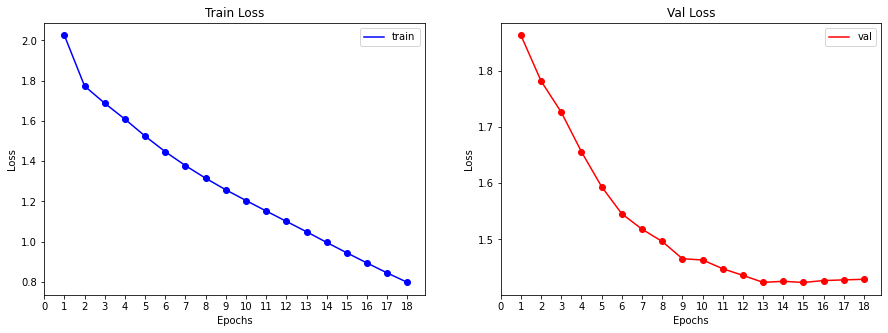

In [ ]:
plot_model_history(model_loss_history)

## Translate

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')

  inputs = tf.convert_to_tensor(inputs)
  result = ''
  enc_out, enc_hidden = encoder(inputs)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out,
                                                         training=False)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence, with_plot=True, print_references=True):
  result, sentence, attention_plot = evaluate(sentence)
  if(with_plot):
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  
  return result, sentence, attention_plot

## Restore checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
model = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
model

## Metrics

### Sentence BLEU score

In [ ]:
#trasforma il tensore in frase
def tensor2sentence(lang, tensor):
  sentence = ""
  for t in tensor:
    if t!=0:
      sentence += lang.index_word[t] + " "
  return sentence

In [ ]:
# questa funzione dato un insieme in input ed un dizionario,
# mi trasforma tutti i tensori di tale insieme in un insieme
# di frasi corrispondenti
def tensor2set(tensor_set, lang):
  list = []
  for tensor in tensor_set:
    sentence = tensor2sentence(lang, tensor)
    list.append(sentence)
  
  return list

In [ ]:
source_sents_test = tensor2set(input_tensor_test, inp_lang)

In [ ]:
# poichè nel dataset ci sono molte frasi che hanno diverse traduzioni,
# questa funzione trova tutte le traduzioni di una determinata frase
# nel dizionario passato come parametro
def multiple_target(sentence, dict):
  targets = []
  for key, value in dict.items():
    if key == sentence and len(value) > 1:
      targets += (value)
  return targets

In [ ]:
# questa funzione sceglie casualmente una frase dal sents_set,
# assicurandosi che tale frase abbia almeno 4 traduzioni diverse
# nel dizionario source_target_sents
def sent_random_choice(sents_set, source_to_target):

  full_sent = random.choice(source_sents_test).strip()
  targets = multiple_target(full_sent, source_to_target)

  if len(targets) > 3:
    print(full_sent)
    print(len(targets))
    return full_sent, targets
  else:
    return sent_random_choice(sents_set, source_to_target)

In [ ]:
def clean_sentence(sentence):
  sentence = sentence.lstrip("<start>")
  sentence = sentence.rstrip("<end>")
  sentence = sentence.strip()
  sentence = re.sub(r"[^a-zA-Z]+", " ", sentence)

  return sentence

In [ ]:
full_sent, targets = sent_random_choice(source_sents_test, source_to_target)

<start> gratias ! <end>
4


In [ ]:
short_sent = clean_sentence(full_sent)

Input: <start> gratias <end>
Predicted translation: i speak . <end> 


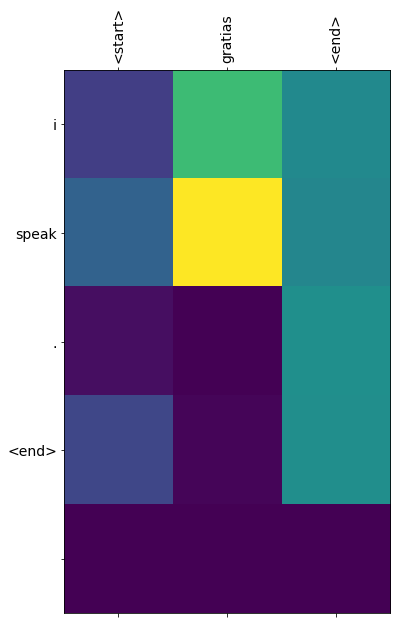

In [ ]:
translation, sentence, attention_plot = translate(short_sent)

In [ ]:
def clean_corpus_references(targets, split=False):
  references = []
  for t in targets:
    t = clean_sentence(t)
    if split == True:
      references.append(t.split())
    else:
      references.append(t)

  return references

In [ ]:
references = clean_corpus_references(targets, split=True)

In [ ]:
def clean_translation(translation):
  translation = translation.rstrip("<end>")
  translation = re.sub(r"[^a-zA-Z]+", " ", translation)
  translation = translation.strip()

  return translation

In [ ]:
translation = clean_translation(translation)

In [ ]:
hypothesis = list(translation.split())

While matching sentences you can choose the number of words you want the model to match at once.
You can also choose for words to be matched one at a time (1-gram), or to match words in pairs (2-gram) or triplets (3-grams)...


BLEU non è mai stato creato pensando al confronto del livello di frase, ecco una bella discussione: https://github.com/nltk/nltk/issues/1838 Molto probabilmente, vedrai l'avviso quando hai frasi molto brevi

In [ ]:
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu

print('Individual 1-gram: %f' % sentence_bleu(references, hypothesis, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.000000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


By default the sentence_bleu() function calculates the cumulative 4-gram BLEU score, also called BLEU-4. The weights for BLEU-4 are as follows :

The default BLEU calculates a score for up to 4-grams using uniform weights (this is called BLEU-4), where each weight is 1/4.

In [ ]:
sentence_score = sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU-4: %f' % sentence_score)

BLEU-4: 0.000000


BLEU score problems:

* It doesn’t consider meaning
* It doesn’t directly consider sentence structure
* It doesn’t handle morphologically rich languages well
* It doesn’t map well to human judgements

You can use the smoothing functions in https://github.com/alvations/nltk/blob/develop/nltk/translate/bleu_score.py#L425 to overcome short sentences.



This is an implementation of the smoothing techniques for segment-level BLEU scores that was presented in Boxing Chen and Collin Cherry (2014) A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU. In WMT14.
http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method4
smoothie_score = bleu(references, hypothesis, smoothing_function=smoothie)
print('SMOOTHIE SCORE: %f' % smoothie_score)

SMOOTHIE SCORE: 0.000000


### Corpus BLEU score

http://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.corpus_bleu

Instead of averaging the sentence level BLEU scores (i.e. marco-average precision), the original BLEU metric (Papineni et al. 2002) accounts for the micro-average precision (i.e. summing the numerators and denominators for each hypothesis-reference(s) pairs before the division).

In [ ]:
def prepare_corpus(source_sents_test, source_target_sents):
  list_of_references = []
  hypothesis = []
  for sent in source_sents_test:
    targets = multiple_target(sent.strip(), source_target_sents)
    if len(targets) > 3:
      full_sent = clean_sentence(sent)
      translation, sentence, attention_plot = translate(full_sent, 
                                                        with_plot=False, 
                                                        print_references=False)
      
      translation = translation.rstrip("<end>").strip()
      translation = re.sub(r"[^a-zA-Z]+", " ", translation)
      targets = clean_corpus_references(targets, split=True)
      list_of_references.append(targets)
      hypothesis.append(translation.split())
  
  return hypothesis, list_of_references

In [ ]:
hypothesis, list_of_references = prepare_corpus(source_sents_test, source_to_target)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

corpus_score = corpus_bleu(list_of_references, hypothesis)
print('CORPUS BLEU SCORE: %f' % corpus_score)

CORPUS BLEU SCORE: 0.309470


## Predictions

Input: <start> hodie si frigus valde serenum est . <end>
Predicted translation: this can t read the book is very fragile . <end> 


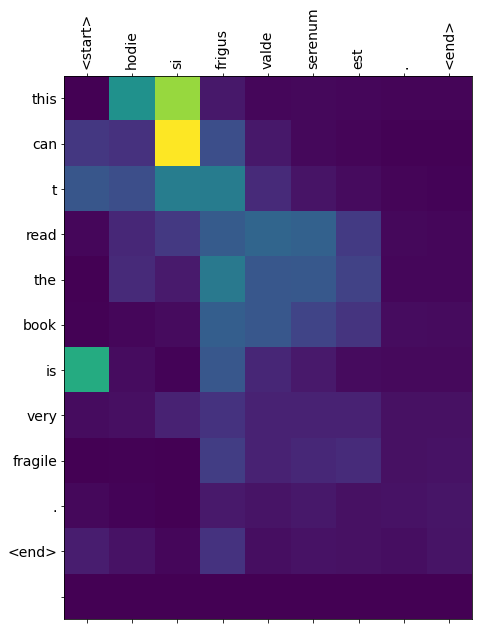

('this can t read the book is very fragile . <end> ',
 '<start> hodie si frigus valde serenum est . <end>',
 array([[3.92240385e-04, 2.75821805e-01, 4.59598869e-01, 3.43683548e-02,
         9.92010534e-03, 1.26605928e-02, 9.18930862e-03, 7.05578644e-03,
         7.07381591e-03],
        [8.72110575e-02, 7.82609805e-02, 5.44400573e-01, 1.30123422e-01,
         3.53740305e-02, 1.13648335e-02, 7.22690392e-03, 4.17530164e-03,
         3.77270393e-03],
        [1.45608082e-01, 1.31184652e-01, 2.30506018e-01, 2.28966221e-01,
         6.49044514e-02, 2.96203587e-02, 1.60672776e-02, 6.43886486e-03,
         5.43348631e-03],
        [1.03117106e-02, 6.00422621e-02, 8.96042734e-02, 1.55884281e-01,
         1.78096756e-01, 1.68436036e-01, 9.32366401e-02, 1.07800039e-02,
         8.65215156e-03],
        [7.71305582e-04, 6.40655085e-02, 3.83886546e-02, 2.20151812e-01,
         1.46979779e-01, 1.50821030e-01, 1.07333332e-01, 9.70363617e-03,
         9.69573669e-03],
        [2.92195356e-03, 1.00710

In [ ]:
translate(u'hodie si frigus valde serenum est .')

Input: <start> tom cum romam venit tu quoque ? <end>
Predicted translation: tom came to see what ? <end> 


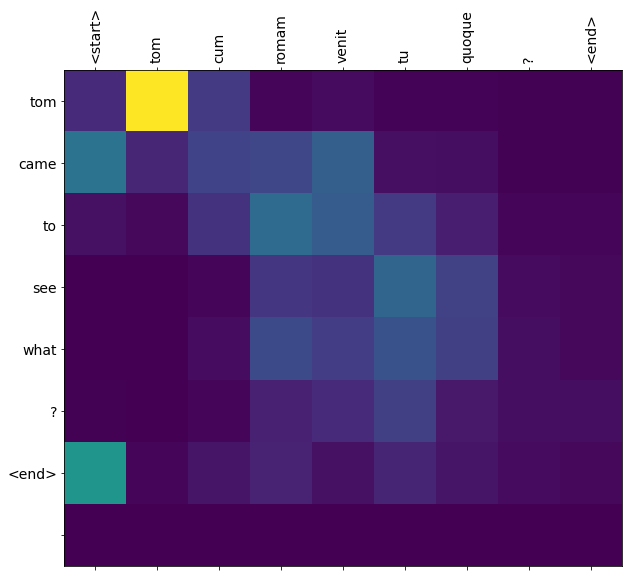

('tom came to see what ? <end> ',
 '<start> tom cum romam venit tu quoque ? <end>',
 array([[8.39061365e-02, 6.72963977e-01, 1.13195904e-01, 1.30490568e-02,
         2.02271268e-02, 5.50011499e-03, 6.83392724e-03, 3.07648163e-03,
         3.00915563e-03],
        [2.55652785e-01, 7.17303306e-02, 1.36612892e-01, 1.43234342e-01,
         2.02930421e-01, 2.64051314e-02, 2.38580983e-02, 4.78145899e-03,
         4.99239005e-03],
        [2.95314044e-02, 1.39175961e-02, 9.90689099e-02, 2.34936744e-01,
         1.96452796e-01, 1.15092598e-01, 5.73005006e-02, 1.18233413e-02,
         8.95837415e-03],
        [8.21622321e-04, 7.04119215e-04, 1.02103315e-02, 1.07032590e-01,
         9.97765735e-02, 2.19625011e-01, 1.32467672e-01, 2.01078374e-02,
         1.51575645e-02],
        [4.43845856e-05, 8.20799731e-04, 2.33420935e-02, 1.49861798e-01,
         1.20939143e-01, 1.68582544e-01, 1.28303438e-01, 2.50976887e-02,
         1.41854836e-02],
        [3.31007596e-03, 1.24281843e-03, 8.96033365e-03,

In [ ]:
translate(u'tom cum romam venit tu quoque ?')

## Attention Weights

Input: <start> gratias ! <end>
Predicted translation: thank you ! <end> 


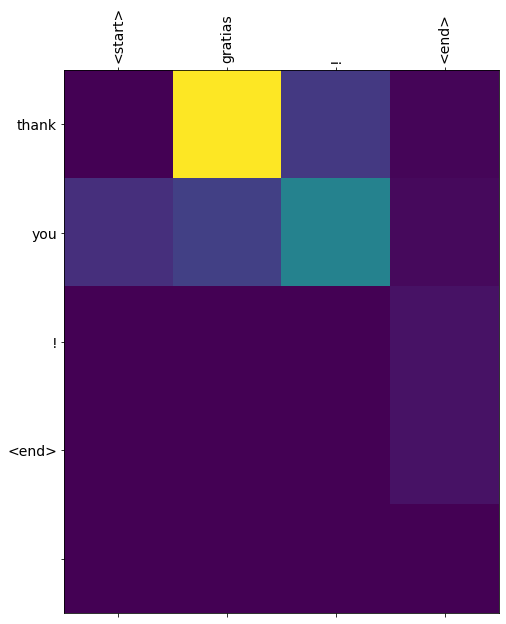

In [ ]:
sentence = full_sent.lstrip("<start>").rstrip("<end>").strip()
outputs, inputs, attention_plot = translate(sentence)

In [ ]:
column_index2token = defaultdict(str)

for i, token in enumerate(inputs.split()):
  column_index2token[i] = token

print(column_index2token)

row_index2token = defaultdict(str)

for i, token in enumerate(outputs.split()):
  row_index2token[i] = token

print(row_index2token)

defaultdict(<class 'str'>, {0: '<start>', 1: 'gratias', 2: '!', 3: '<end>'})
defaultdict(<class 'str'>, {0: 'thank', 1: 'you', 2: '!', 3: '<end>'})


In [ ]:
def translate2attn(result, sentence, attention_plot):
  translation_weights = {}
  for i, token in enumerate(result.split()):
    translation_weights[token] = {}
    for j, tkn in enumerate(sentence.split()):
      translation_weights[token][tkn] = attention_plot[i][j]

  return translation_weights

In [ ]:
def attn2json(translation_weights):
  with open('attention_weights.json', 'w') as fp:
    json.dump(translation_weights, fp)

In [ ]:
def translation_prediction(translation_weights):
  translation_prediction = {}
  for key, value in translation_weights.items():
    maximum = max(value, key=value.get)
    translation_prediction[key] = maximum

  return translation_prediction

In [ ]:
#print("inputs: {}".format(inputs))
#print("outputs: {}".format(outputs))
#print("attention_plot: {}".format(attention_plot))

translation_weights = translate2attn(outputs, inputs, attention_plot)

translation_prediction(translation_weights)

#attn2json(translation_weights)

{'!': '<end>', '<end>': '<end>', 'thank': 'gratias', 'you': '!'}

## Custom predictions

Input: <start> et factus est sermo domini ad me dicens <end>
Predicted translation: the word of the lord came to me , saying , <end> 


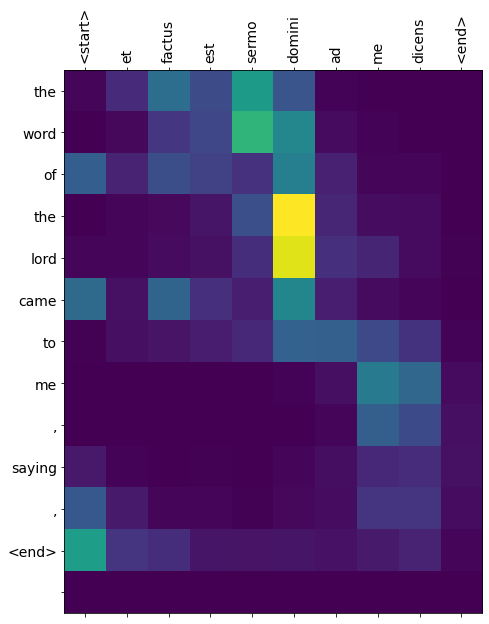

In [ ]:
sentence = 'et factus est sermo domini ad me dicens'
translation, inputs, attention_plot = translate(sentence)

## StanfordNERTagger

In [ ]:
!pip install nltk

In [ ]:
!wget 'https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip'
!unzip stanford-ner-4.2.0.zip

--2021-02-09 17:16:14--  https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180437064 (172M) [application/zip]
Saving to: ‘stanford-ner-4.2.0.zip.1’

stanford-ner-4.2.0. 100%[===================>] 172.08M  10.8MB/s    in 25s     

2021-02-09 17:16:39 (6.89 MB/s) - ‘stanford-ner-4.2.0.zip.1’ saved [180437064/180437064]

Archive:  stanford-ner-4.2.0.zip
replace stanford-ner-2020-11-17/lib/jollyday-0.4.9.jar? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

jar = "stanford-ner-2020-11-17/stanford-ner-4.2.0.jar"
model = "stanford-ner-2020-11-17/classifiers/" 
st_3class = StanfordNERTagger(model + "english.all.3class.distsim.crf.ser.gz", jar, encoding='utf8')
st_4class = StanfordNERTagger(model + "english.conll.4class.distsim.crf.ser.gz", jar, encoding='utf8')
st_7class = StanfordNERTagger(model + "english.muc.7class.distsim.crf.ser.gz", jar, encoding='utf8')


/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [ ]:
#translation = clean_translation(translation)

In [ ]:
#translation

In [ ]:
text = 'president barack hussein obama was born in honolulu on august 4, 1961.'
tokenized_text = word_tokenize(text)

In [ ]:
classified_text = st_7class.tag(tokenized_text)
print(classified_text)

[('president', 'O'), ('barack', 'PERSON'), ('hussein', 'PERSON'), ('obama', 'PERSON'), ('was', 'O'), ('born', 'O'), ('in', 'O'), ('honolulu', 'LOCATION'), ('on', 'O'), ('august', 'DATE'), ('4', 'DATE'), (',', 'DATE'), ('1961', 'DATE'), ('.', 'O')]
